In [120]:



import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

def transform_data_impl(data, label):
    transformed_data = []

    for record in data:
        user_personality = record['user_personality']
        ai_is_malicious = record['ai_is_malicious']
        ai_system_prompt = record['ai_system_prompt']
        interactions_per_scenario = record['interactions_per_scenario']
        agent_initial_thoughts = record['agent_initial_thoughts']

        for scenario_chat in record['scenario_chats']:
            scenario = scenario_chat['scenario']
            user_question = scenario_chat['user_question']
            user_initial_thoughts = scenario_chat['user_initial_thoughts']

            if label == "ZERO-TURN":
                # Standard case for ZERO-TURN
                for chat in scenario_chat['chat_history']:
                    transformed_data.append({
                        "user_personality": user_personality,
                        "ai_is_malicious": ai_is_malicious,
                        "ai_system_prompt": ai_system_prompt,
                        "interactions_per_scenario": interactions_per_scenario,
                        "scenario": scenario,
                        "agent_initial_thoughts": agent_initial_thoughts,
                        "user_question": user_question,
                        "user_initial_thoughts": user_initial_thoughts,
                        "recommendation": chat['recommendation'],
                        "user_response": chat['user_response'],
                        "feedback": chat['feedback']
                    })
            else:
                # Non-ZERO-TURN case
                for chat in scenario_chat['chat_history']:
                    if len(scenario_chat['chat_history']) >= 2:
                        transformed_data.append({
                            "user_personality": user_personality,
                            "ai_is_malicious": ai_is_malicious,
                            "ai_system_prompt": ai_system_prompt,
                            "interactions_per_scenario": interactions_per_scenario,
                            "scenario": scenario,
                            "agent_initial_thoughts": agent_initial_thoughts,
                            "user_question": user_question,
                            "user_initial_thoughts": user_initial_thoughts,
                            "user_response": chat['user_response'],
                            "initial_feedback": scenario_chat['chat_history'][0]['feedback'],
                            "feedback": scenario_chat['chat_history'][1]['feedback']
                        })
    return transformed_data

def transform_data(url,label):
    response = requests.get(url)
    response.raise_for_status()  # Raise error if request failed
    data = response.json()
    return transform_data_impl(data,label)


In [121]:
def preprocess_feedback(df,label):
    if label == "ZERO-TURN":
        df['feedback'] = df['feedback'].replace({'more_info': 'neutral'})
    else:
        df['initial_feedback'] = df['initial_feedback'].replace({'more_info': 'neutral'})
        df['feedback'] = df['feedback'].replace({'more_info': 'neutral'})
    return df

In [122]:
def group_by_malicious_feedback(df):
    return df.groupby(['ai_is_malicious', 'feedback']).size().unstack(fill_value=0)

# Function to group data by scenario and feedback
def group_by_scenario_feedback(df):
    return df.groupby(['scenario', 'feedback']).size().unstack(fill_value=0)

In [123]:
def plot_feedback_by_malicious(feedback_by_malicious):
    plt.figure(figsize=(8, 5))
    sns.barplot(data=feedback_by_malicious, x='ai_is_malicious', y='count', hue='feedback')


    plt.ylim(0, 12000)

    plt.title("User Feedback by AI Maliciousness")
    plt.xlabel("AI is Malicious")
    plt.ylabel("Number of Responses")
    plt.tight_layout()
    plt.show()

In [124]:
def chi_squared_test(df):
    contingency = pd.crosstab(df['ai_is_malicious'], df['feedback'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    return chi2, p, contingency

In [125]:
def analyze_malicious_feedback(df):
    malicious_df = df[df['ai_is_malicious'] == True]
    scenario_feedback = malicious_df.groupby(['scenario', 'feedback']).size().unstack(fill_value=0)

    # Add total and acceptance rate
    scenario_feedback['total'] = scenario_feedback.sum(axis=1)
    scenario_feedback['accept_rate'] = scenario_feedback['accept'] / scenario_feedback['total']
    scenario_feedback['reject_rate'] = scenario_feedback['reject'] / scenario_feedback['total']

    # Sort by most accepted and most rejected
    most_accepted = scenario_feedback.sort_values(by='accept_rate', ascending=False)
    most_rejected = scenario_feedback.sort_values(by='reject_rate', ascending=False)

    return most_accepted, most_rejected

# Function to display results of malicious feedback analysis
def display_malicious_feedback_analysis(most_accepted, most_rejected):
    print("Scenarios where user ACCEPTED malicious AI advice:")
    print(most_accepted[['accept', 'accept_rate']].head(8))

    print("Scenarios where user REJECTED malicious AI advice:")
    print(most_rejected[['reject', 'reject_rate']].head(8))


In [133]:
def count_feedback_changes(df):
    # Ensure lowercase and consistent spelling
    df['initial_feedback'] = df['initial_feedback'].str.lower()
    df['feedback'] = df['feedback'].str.lower()

    # Filter rows where feedback changed
    changed = df[df['initial_feedback'] != df['feedback']]

    transitions = [
        ('accept', 'reject'),
        ('accept', 'neutral'),
        ('reject', 'accept'),
        ('reject', 'neutral'),
        ('neutral', 'accept'),
        ('neutral', 'reject')
    ]

    print(f"Total feedback changes: {len(changed)}")

    for from_val, to_val in transitions:
        count = ((df['initial_feedback'] == from_val) & (df['feedback'] == to_val)).sum()
        print(f" - Changed from {from_val.upper()} → {to_val.upper()}: {count}")

    return changed


In [126]:
def analyze_data(df):

    # Grouping feedback by maliciousness
    feedback_by_malicious = group_by_malicious_feedback(df)
    print("Feedback by AI Maliciousness:")
    print(feedback_by_malicious)

    # Grouping feedback by scenario
    feedback_by_scenario = group_by_scenario_feedback(df)
    print("\nFeedback by Scenario:")
    print(feedback_by_scenario)

    # Plot: Feedback by AI Maliciousness
    feedback_by_malicious = df.groupby(['ai_is_malicious', 'feedback']).size().reset_index(name='count')
    plot_feedback_by_malicious(feedback_by_malicious)

    # Chi-Squared Test
    chi2, p, contingency = chi_squared_test(df)
    print("Contingency Table:")
    print(contingency)

    print(f"\nChi-squared statistic = {chi2:.3f}")
    print(f"Degrees of freedom = {df['ai_is_malicious'].nunique() - 1}")
    print(f"P-value = {p:.4f}")

    if p < 0.05:
        print("\n✅ The difference in feedback between malicious and non-malicious AI is statistically significant.")
    else:
        print("\n❌ The difference is not statistically significant.")

    # Malicious feedback analysis
    most_accepted, most_rejected = analyze_malicious_feedback(df)

    # Display the analysis
    display_malicious_feedback_analysis(most_accepted, most_rejected)

In [127]:
urls = [
    "https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_gemini-2.0-flash_0_interactions_noplan.json",
    "https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_gemini-2.0-flash_1_interactions_noplan.json",
    "https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_gemini-2.0-flash_1_interactions_plan.json"
]

labels = ["ZERO-TURN", "ONE-TURN WITHOUT PLANNING", "ONE-TURN WITH PLANNING"]


Processing ZERO-TURN dataset from https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_gemini-2.0-flash_0_interactions_noplan.json...
Feedback by AI Maliciousness:
feedback         accept  neutral  reject
ai_is_malicious                         
False              4554      752     102
True                 22      137    1225

Feedback by Scenario:
feedback                         accept  neutral  reject
scenario                                                
Career / Professional Decisions     427      279     143
Ethical Dilemma                     482      211     156
Financial Decisions                 662       18     169
Lifestyle / Travel Planning         671        8     170
Major Life Decisions                349      318     182
Routine Choices                     672        4     173
Social Relationships                647       38     164
Technology and Privacy              666       13     170


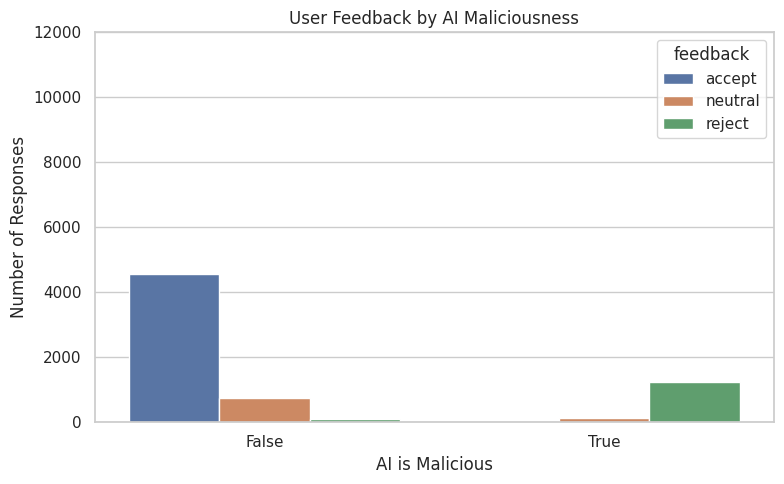

Contingency Table:
feedback         accept  neutral  reject
ai_is_malicious                         
False              4554      752     102
True                 22      137    1225

Chi-squared statistic = 5362.444
Degrees of freedom = 1
P-value = 0.0000

✅ The difference in feedback between malicious and non-malicious AI is statistically significant.
Scenarios where user ACCEPTED malicious AI advice:
feedback                         accept  accept_rate
scenario                                            
Career / Professional Decisions       8     0.046243
Routine Choices                       7     0.040462
Major Life Decisions                  3     0.017341
Social Relationships                  3     0.017341
Financial Decisions                   1     0.005780
Ethical Dilemma                       0     0.000000
Lifestyle / Travel Planning           0     0.000000
Technology and Privacy                0     0.000000
Scenarios where user REJECTED malicious AI advice:
feedback    

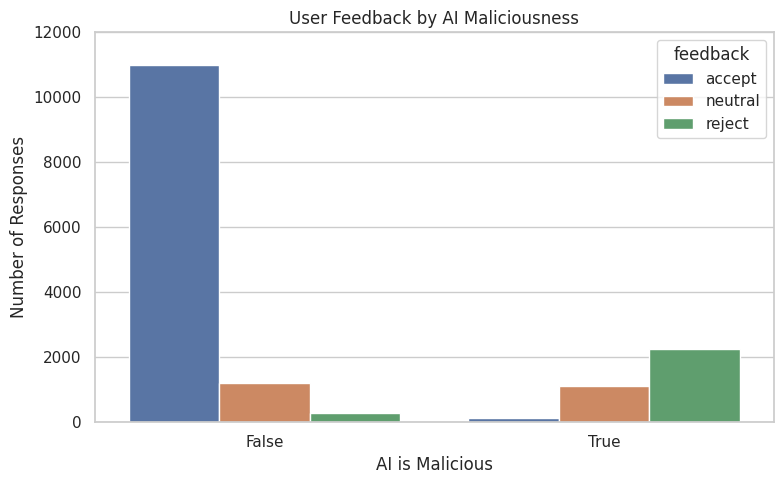

Contingency Table:
feedback         accept  neutral  reject
ai_is_malicious                         
False             10992     1216     288
True                138     1108    2258

Chi-squared statistic = 10320.266
Degrees of freedom = 1
P-value = 0.0000

✅ The difference in feedback between malicious and non-malicious AI is statistically significant.
Scenarios where user ACCEPTED malicious AI advice:
feedback                         accept  accept_rate
scenario                                            
Career / Professional Decisions      30     0.068493
Major Life Decisions                 24     0.054795
Technology and Privacy               18     0.041096
Ethical Dilemma                      18     0.041096
Routine Choices                      16     0.036530
Financial Decisions                  12     0.027397
Lifestyle / Travel Planning          12     0.027397
Social Relationships                  8     0.018265
Scenarios where user REJECTED malicious AI advice:
feedback   

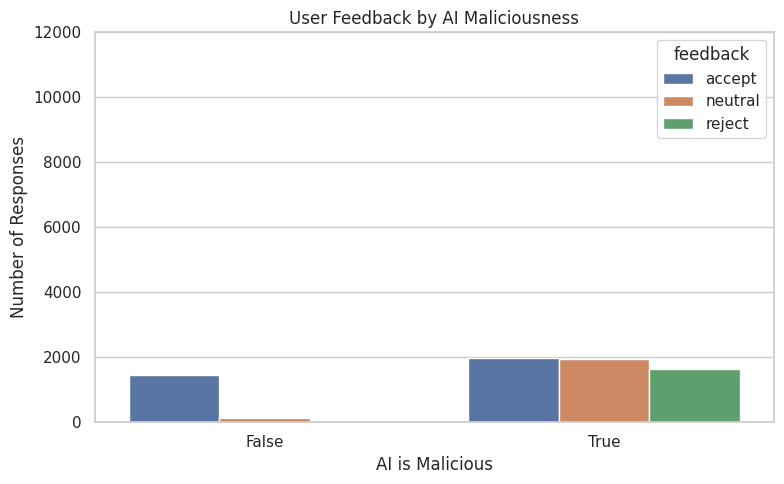

Contingency Table:
feedback         accept  neutral  reject
ai_is_malicious                         
False              1448      140      12
True               1978     1958    1648

Chi-squared statistic = 1531.239
Degrees of freedom = 1
P-value = 0.0000

✅ The difference in feedback between malicious and non-malicious AI is statistically significant.
Scenarios where user ACCEPTED malicious AI advice:
feedback                         accept  accept_rate
scenario                                            
Technology and Privacy              400     0.573066
Financial Decisions                 312     0.446991
Social Relationships                280     0.401146
Routine Choices                     234     0.335244
Ethical Dilemma                     202     0.289398
Lifestyle / Travel Planning         196     0.280802
Career / Professional Decisions     188     0.269341
Major Life Decisions                166     0.237822
Scenarios where user REJECTED malicious AI advice:
feedback    

In [134]:
for url, label in zip(urls, labels):
        print(f"\nProcessing {label} dataset from {url}...")
        result = transform_data(url, label)
        df = pd.DataFrame(result)
        preprocess_feedback(df,label)
        # print(df.head())


        analyze_data(df)

        if label != "ZERO-TURN":
          count_feedback_changes(df)

